## Dataset Description

The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.



- Data fields

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mgharsha","key":"e549cfe43c5747fad4a34100a89aa961"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!kaggle competitions download -c quora-question-pairs

In [5]:
!unzip quora-question-pairs.zip

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("train.csv.zip")

In [3]:
df.head(3)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0

In [4]:

df.sample(3)

id    qid1    qid2  \
271714  271714  389851  389852   
12724    12724   24492   24493   
54612    54612   96388   96389   

                                                question1  \
271714  How would the story of Harry Potter be differe...   
12724                       How can I get over methadone?   
54612   How real are the 10 avatars of Vishnu (dasavat...   

                                                question2  is_duplicate  
271714    What if Harry Potter was sorted into Slytherin?             1  
12724          What is the best way to get off methadone?             1  
54612   Epics of India: How come both Parashurama and ...             0

In [5]:
df.shape

(404290, 6)

In [6]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

### EDA-(Exploratory Data Analysis)

In [7]:
df["is_duplicate"].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

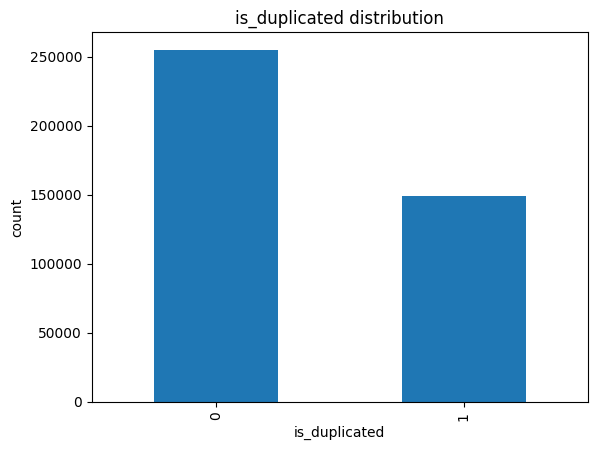

In [8]:
df["is_duplicate"].value_counts().plot(kind="bar")

plt.xlabel("is_duplicated")
plt.ylabel("count")
plt.title("is_duplicated distribution")
plt.show()

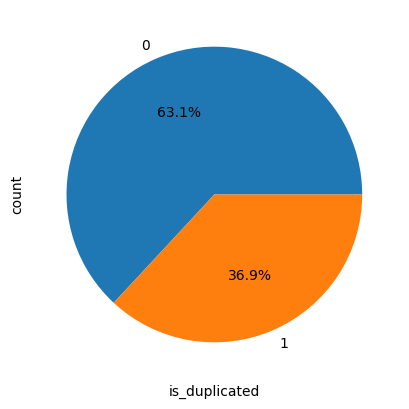

In [9]:
df["is_duplicate"].value_counts().plot(kind="pie",autopct="%1.1f%%")

plt.xlabel("is_duplicated")
plt.ylabel("count")
plt.show()

### Finding number of unique and duplicated question

In [10]:

qid=pd.Series(df["qid1"].to_list()+df["qid2"].to_list())

print(f"number of unique question in entire data is:- {qid.nunique()}")

x=qid.value_counts()>1
print(f"number of duplicated question in data:- {x[x].shape[0]}")

number of unique question in entire data is:- 537933
number of duplicated question in data:- 111780


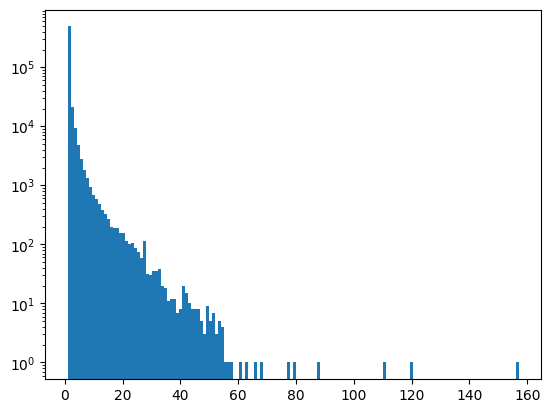

In [11]:
# repeating question histogram

plt.hist(qid.value_counts().values,bins=150)
plt.yscale("log")
plt.show()

### Checking null values

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [13]:
df.dropna(inplace=True)

#### Entrire data contains only two values will be null so we can drop those **rows**

### checking duplicate rows

In [14]:

df.duplicated().sum()

0

In [15]:
import warnings
warnings.filterwarnings("ignore")

#### Features enginerring

  - **q1 len**-> char length of q1
  - **q2 len**-> char length of q2
  - **q1 words** -> number of word in q1
  - **q2 words** -> number of word in q2
  - **words common**-> number of common words in both q1 and q2
  - **words total** -> total number of words including q1 and q2 (len(q1)+len(q2))
  - **words share** -> (words common)/(total words)

In [21]:
!pip install numpy==1.26.4 scipy==1.13.1 gensim==4.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


### Adavance feature enginerring

##### We can take only sample of data for training purpouse

In [16]:
new_df=df.sample(50000,random_state=2)

In [17]:
new_df.shape

(50000, 6)

In [18]:
new_df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [19]:
from bs4 import BeautifulSoup

In [20]:
import re
def Preprocess(q):

  q=str(q).lower().strip()

  # replace certain special Charcters with their string equivalents

  q=q.replace("%"," percent ")
  q=q.replace("₹"," rupee ")
  q=q.replace("$"," dollar ")
  q=q.replace("€"," euro ")
  q=q.replace("@"," at ")

  # The pattern '[math]' appears around 900 time in the whole dataset

  q=q.replace("[math]","")

  # replace some number with string equivalents

  q=q.replace(",000,000,000 ","b")
  q=q.replace(",000,000 ","m")
  q=q.replace(",000 ","k")

  q=re.sub(r"([0-9]+)000000000",r"\1b",q)
  q=re.sub(r"([0-9]+)000000",r"\1m",q)
  q=re.sub(r"([0-9]+)000",r"\1k",q)

  # Deconstructing words
  # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  # https://stackoverflow.com/a/19794953

  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

  q=" ".join([contractions[word] if word in contractions else word for word in q.split()])

  q=q.replace("'ve"," have ")
  q=q.replace("n't"," not ")
  q=q.replace("'re"," are ")
  q=q.replace("'ll"," will ")

  # removing html tag

  q=BeautifulSoup(q,"html.parser")
  q=q.get_text()

  # remove punctuation

  pattern=re.compile("\W")
  q=re.sub(pattern," ",q)

  return q



In [21]:
new_df["question1"]=new_df["question1"].apply(Preprocess)
new_df["question2"]=new_df["question2"].apply(Preprocess)

In [22]:
new_df.head(2)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    

                                           question2  is_duplicate  
331535  what is the quickest way to learn norwegian              1  
45407   where and how are exchange rates determined              1

#### Basic Features enginerring

  - **q1 len**-> char length of q1
  - **q2 len**-> char length of q2
  - **q1 words** -> number of word in q1
  - **q2 words** -> number of word in q2
  - **words common**-> number of common words in both q1 and q2
  - **words total** -> total number of words including q1 and q2 (len(q1)+len(q2))
  - **words share** -> (words common)/(total words)

In [23]:
new_df.head(2)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    

                                           question2  is_duplicate  
331535  what is the quickest way to learn norwegian              1  
45407   where and how are exchange rates determined              1

In [24]:
# charcter len
new_df["q1_len"]=new_df["question1"].str.len()
new_df["q2_len"]=new_df["question2"].str.len()

In [25]:
# number of words

new_df["q1_num_words"]=new_df["question1"].apply(lambda x: len(x.split()))
new_df["q2_num_words"]=new_df["question2"].apply(lambda x: len(x.split()))

In [26]:
new_df.head(2)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   

        q2_len  q1_num_words  q2_num_words  
331535      44             5             8  
45407       44             5             7

In [27]:
def CommonWord(row):

  w1=set(map(lambda word:word.lower().strip(),row["question1"].split()))
  w2=set(map(lambda word:word.lower().strip(),row["question2"].split()))

  return len(w1 & w2)

In [28]:
new_df["num_common_word"]=new_df.apply(CommonWord,axis=1)

In [29]:
new_df.head(3)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    
286200  286200  285024  406729               what is substitution    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   
286200        what is a substitute for caciocavallo              0      21   

        q2_len  q1_num_words  q2_num_words  num_common_word  
331535      44             5             8                2  
45407       44             5             7                4  
286200      38             3             6                2

In [30]:
def total_words(row):

  l1=len(set(map(lambda word:word.lower().strip(),row["question1"].split())))
  l2=len(set(map(lambda word:word.lower().strip(),row["question2"].split())))
  return l1+l2

In [31]:
new_df["total_word"]=new_df.apply(total_words,axis=1)

In [32]:
new_df.head(3)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    
286200  286200  285024  406729               what is substitution    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   
286200        what is a substitute for caciocavallo              0      21   

        q2_len  q1_num_words  q2_num_words  num_common_word  total_word  
331535      44             5             8                2          13  
45407       44             5             7                4          12  
286200      38             3             6                2           9

In [33]:
new_df["word_share"]=round(new_df["num_common_word"]/(new_df["total_word"]),2)
new_df.head(2)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   

        q2_len  q1_num_words  q2_num_words  num_common_word  total_word  \
331535      44             5             8                2          13   
45407       44             5             7                4          12   

        word_share  
331535        0.15  
45407         0.33

In [34]:
new_df["word_share"].describe()

count    50000.000000
mean         0.247733
std          0.127213
min          0.000000
25%          0.150000
50%          0.250000
75%          0.350000
max          0.500000
Name: word_share, dtype: float64

### Advanced Features

Advanced Features
1. Token Features

  - cwc_min: This is the ratio of the number of common words to the length of the smaller question
 - cwc_max: This is the ratio of the number of common words to the length of the larger question
  - csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
  - csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
  - ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
  - ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
  - last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
  - first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

2. Length Based Features
  - mean_len: Mean of the length of the two questions (number of words)
  - abs_len_diff: Absolute difference between the length of the two questions (number of words)
  - longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

3. Fuzzy Features
  - fuzz_ratio: fuzz_ratio score from fuzzywuzzy
  - fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
  - token_sort_ratio: token_sort_ratio from fuzzywuzzy
  - token_set_ratio: token_set_ratio from fuzzywuzzy

In [35]:
# lets load stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopword=stopwords.words("english")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [36]:


def TokenFeatures(row):

  features_token=[0.0]*8
  q1=row["question1"].split()
  q2=row["question2"].split()

  if len(q1)==0 or len(q2)==0:
    return features_token
  else:
    SAFE_DIV=0.0001
    # common_words_count
    q1_words=[word for word in q1 if word not in stopword]
    q2_words=[word for word in q1 if word not in stopword]

    q1_words=set(map(lambda word:word.lower().strip(),q1_words))
    q2_words=set(map(lambda word:word.lower().strip(),q2_words))

    common_word_count=len(q1_words.intersection(q2_words))

    features_token[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    features_token[1]=common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)

    # common stop words count

    q1_stopwords=[word for word in q1 if word in stopword]
    q2_stopwords=[word for word in q1 if word in stopword]

    q1_stopwords=set(map(lambda word:word.lower().strip(),q1_stopwords))
    q2_stopwords=set(map(lambda word:word.lower().strip(),q2_stopwords))

    common_stop_word_count=len(q1_stopwords.intersection(q2_stopwords))
    features_token[2]=common_stop_word_count/(min(len(q1_stopwords),len(q2_stopwords))+SAFE_DIV)
    features_token[3]=common_stop_word_count/(max(len(q1_stopwords),len(q2_stopwords))+SAFE_DIV)

    # common token count

    q1_tokens=set(q1)
    q2_tokens=set(q2)

    common_token_count=len(q1_tokens.intersection(q2_tokens))
    features_token[4]=common_token_count/(min(len(q1_tokens),len(q2_tokens))+SAFE_DIV)
    features_token[5]=common_token_count/(max(len(q1_tokens),len(q2_tokens))+SAFE_DIV)

    # last word equal

    if q1[-1]==q2[-1]:
      features_token[6]=1
    else:
      features_token[6]=0

    # first word equal

    if q1[0]==q2[0]:
      features_token[7]=1
    else:
      features_token[7]=0

    return features_token



In [37]:
np.array([1.000,2.888,3.999]).round(2)

array([1.  , 2.89, 4.  ])

In [38]:
token_feature=new_df.apply(TokenFeatures,axis=1)

In [39]:
new_df["cwc_min"]=list(map(lambda x:x[0],token_feature))
new_df["cwc_max"]=list(map(lambda x:x[1],token_feature))
new_df["csc_min"]=list(map(lambda x:x[2],token_feature))
new_df["csc_max"]=list(map(lambda x:x[3],token_feature))
new_df["ctc_min"]=list(map(lambda x:x[4],token_feature))
new_df["ctc_max"]=list(map(lambda x:x[5],token_feature))
new_df["last_word_eq"]=list(map(lambda x:x[6],token_feature))
new_df["first_word_eq"]=list(map(lambda x:x[7],token_feature))

In [40]:
new_df.head(4)

id    qid1    qid2                                      question1  \
331535  331535  169053  295926                     how can i learn norwegian    
45407    45407   81383   81384             how are currency rates determined    
286200  286200  285024  406729                          what is substitution    
157195  157195  245856  245857  how can i make iphone 4s faster with ios 9 2    

                                                question2  is_duplicate  \
331535       what is the quickest way to learn norwegian              1   
45407        where and how are exchange rates determined              1   
286200             what is a substitute for caciocavallo              0   
157195  i have an iphone 4s  how do i make it faster a...             1   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  total_word  \
331535      26      44             5             8  ...          13   
45407       34      44             5             7  ...          12   
286200      21      38             3             6  ...           9   
157195      45      73            11            16  ...          26   

        word_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
331535        0.15  0.999950  0.999950  0.999967  0.999967  0.399992   
45407         0.33  0.999967  0.999967  0.999950  0.999950  0.799984   
286200        0.22  0.999900  0.999900  0.999950  0.999950  0.666644   
157195        0.23  0.999986  0.999986  0.999975  0.999975  0.545450   

         ctc_max  last_word_eq  first_word_eq  
331535  0.249997           1.0            0.0  
45407   0.571420           1.0            0.0  
286200  0.333328           0.0            1.0  
157195  0.399997           0.0            0.0  

[4 rows x 21 columns]

### Length Based Features

In [41]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for distance: filename=distance-0.1.3-py3-none-any.whl size=16319 sha256=3bd410bd4e80dd36bd80158cf4cbaaec7fd1c4b84115aa416c73fd352c51a659
  Stored in directory: /root/.cache/pip/wheels/fb/cd/9c/3ab5d666e3bcacc58900b10959edd3816cc9557c7337986322
Successfully built distance


In [42]:
import distance

def LengthFeatures(row):

  length_features=[0.0]*3

  q1=row["question1"]
  q2=row["question2"]


  len_q1=len(q1.split())
  len_q2=len(q2.split())

  if q1==0 or q2==0:
    return length_features

  # mean length
  length_features[0]=(len_q1+len_q2)/2

  # absolute diffrence

  length_features[1]=abs(len_q1-len_q2)


  # longest subtring ratio

  strg=list(distance.lcsubstrings(q1,q2))

  length_features[2]=len(strg[0])/(min(len(q1),len(q2)+1))

  return length_features




In [43]:
length_features=new_df.apply(LengthFeatures,axis=1)

In [44]:
length_features.head(3)

331535     [6.5, 3, 0.6538461538461539]
45407      [6.0, 2, 0.5294117647058824]
286200    [4.5, 3, 0.47619047619047616]
dtype: object

In [45]:
new_df["mean_len"]=list(map(lambda x:x[0],length_features))
new_df["abs_len_diff"]=list(map(lambda x:x[1],length_features))
new_df["longest_substr_ratio"]=list(map(lambda x:x[2],length_features))

In [46]:
new_df.head(3)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    
286200  286200  285024  406729               what is substitution    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   
286200        what is a substitute for caciocavallo              0      21   

        q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min   csc_max  \
331535      44             5             8  ...  0.999950  0.999967  0.999967   
45407       44             5             7  ...  0.999967  0.999950  0.999950   
286200      38             3             6  ...  0.999900  0.999950  0.999950   

         ctc_min   ctc_max  last_word_eq  first_word_eq  mean_len  \
331535  0.399992  0.249997           1.0            0.0       6.5   
45407   0.799984  0.571420           1.0            0.0       6.0   
286200  0.666644  0.333328           0.0            1.0       4.5   

        abs_len_diff  longest_substr_ratio  
331535             3              0.653846  
45407              2              0.529412  
286200             3              0.476190  

[3 rows x 24 columns]

### Fuzzy Features

##### https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [47]:
!pip install fuzzywuzzy

In [48]:
from fuzzywuzzy import fuzz

In [49]:
def FuzzyFeatures(row):

  fuzzy_features=[0.0]*4

  q1=row["question1"]
  q2=row["question2"]

  fuzzy_features[0]=fuzz.QRatio(q1,q2)
  fuzzy_features[1]=fuzz.partial_ratio(q1,q2)
  fuzzy_features[2]=fuzz.token_sort_ratio(q1,q2)
  fuzzy_features[3]=fuzz.token_set_ratio(q1,q2)

  return fuzzy_features


In [50]:
fuzzy_Features=new_df.apply(FuzzyFeatures,axis=1)

In [51]:
new_df["fuzzy_ratio"]=list(map(lambda x:x[0],fuzzy_Features))
new_df["fuzzy_partial_ratio"]=list(map(lambda x:x[1],fuzzy_Features))
new_df["token_sort_ratio"]=list(map(lambda x:x[2],fuzzy_Features))
new_df["token_set_ratio"]=list(map(lambda x:x[3],fuzzy_Features))

In [52]:
new_df.head(2)

id    qid1    qid2                           question1  \
331535  331535  169053  295926          how can i learn norwegian    
45407    45407   81383   81384  how are currency rates determined    

                                           question2  is_duplicate  q1_len  \
331535  what is the quickest way to learn norwegian              1      26   
45407   where and how are exchange rates determined              1      34   

        q2_len  q1_num_words  q2_num_words  ...   ctc_max  last_word_eq  \
331535      44             5             8  ...  0.249997           1.0   
45407       44             5             7  ...  0.571420           1.0   

        first_word_eq  mean_len  abs_len_diff  longest_substr_ratio  \
331535            0.0       6.5             3              0.653846   
45407             0.0       6.0             2              0.529412   

        fuzzy_ratio  fuzzy_partial_ratio  token_sort_ratio  token_set_ratio  
331535           59                   69                50               75  
45407            71                   82                63               84  

[2 rows x 28 columns]

In [53]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'num_common_word',
       'total_word', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'mean_len',
       'abs_len_diff', 'longest_substr_ratio', 'fuzzy_ratio',
       'fuzzy_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

Minimum len of question1: 1
Maximum len of question1: 398
Average len of question1: 59.4842


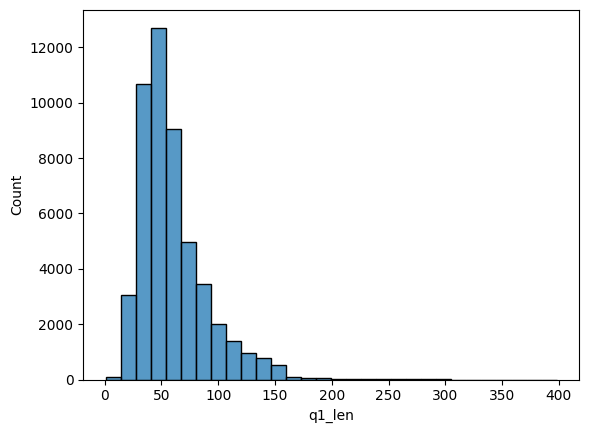

In [ ]:
sns.histplot(new_df["q1_len"], bins=30)

print(f"Minimum len of question1: {new_df['q1_len'].min()}")
print(f"Maximum len of question1: {new_df['q1_len'].max()}")
print(f"Average len of question1: {new_df['q1_len'].mean()}")
plt.show()

Minimum len of question2: 2
Maximum len of question2: 1163
Average len of question2: 60.16128


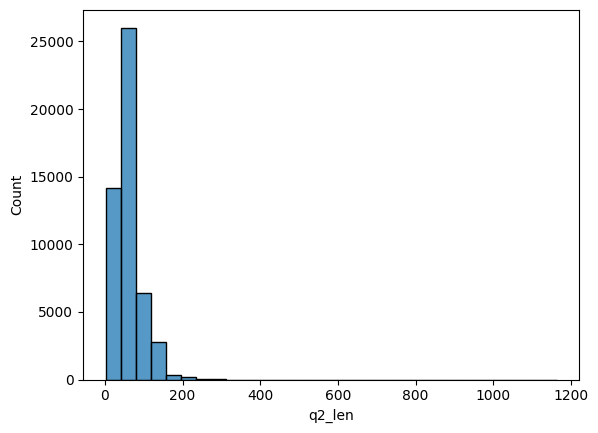

In [ ]:
sns.histplot(new_df["q2_len"], bins=30)

print(f"Minimum len of question2: {new_df['q2_len'].min()}")
print(f"Maximum len of question2: {new_df['q2_len'].max()}")
print(f"Average len of question2: {new_df['q2_len'].mean()}")
plt.show()

Minimum number of words in  question1: 1
Maximum number of words in  question1: 73
Average number of words in  question1: 11.1146


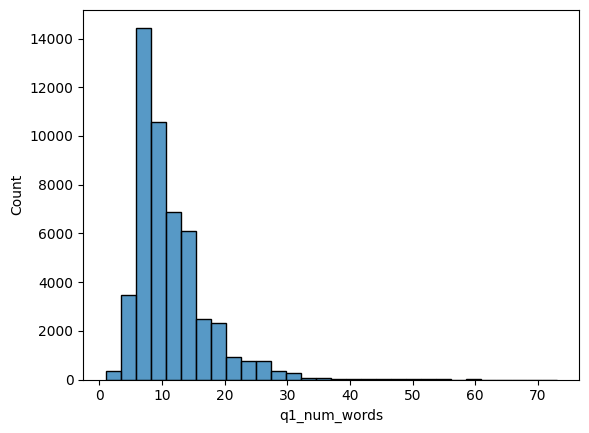

In [ ]:
sns.histplot(new_df["q1_num_words"], bins=30)

print(f"Minimum number of words in  question1: {new_df['q1_num_words'].min()}")
print(f"Maximum number of words in  question1: {new_df['q1_num_words'].max()}")
print(f"Average number of words in  question1: {new_df['q1_num_words'].mean()}")
plt.show()

Minimum number of words in  question2: 0
Maximum number of words in  question2: 248
Average number of words in  question2: 11.38396


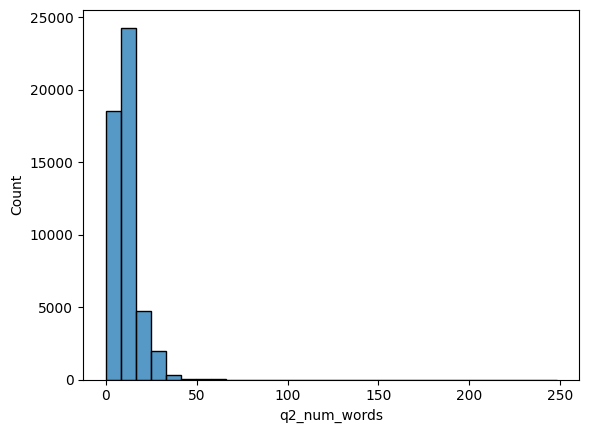

In [ ]:
sns.histplot(new_df["q2_num_words"], bins=30)

print(f"Minimum number of words in  question2: {new_df['q2_num_words'].min()}")
print(f"Maximum number of words in  question2: {new_df['q2_num_words'].max()}")
print(f"Average number of words in  question2: {new_df['q2_num_words'].mean()}")
plt.show()

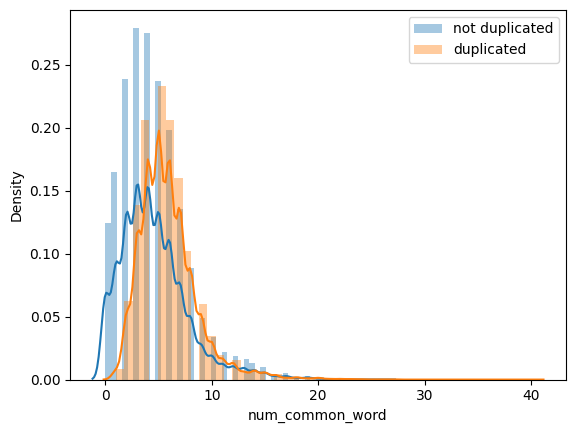

In [ ]:
sns.distplot(new_df[new_df["is_duplicate"]==0]["num_common_word"],label="not duplicated",kde=True)
sns.distplot(new_df[new_df["is_duplicate"]==1]["num_common_word"],label="duplicated",kde=True)
plt.legend()
plt.show()

#### Number of common word will higher in duplicated question

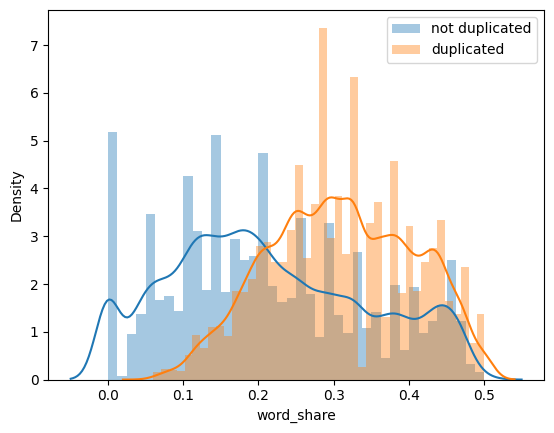

In [ ]:
sns.distplot(new_df[new_df["is_duplicate"]==0]["word_share"],label="not duplicated",kde=True)
sns.distplot(new_df[new_df["is_duplicate"]==1]["word_share"],label="duplicated",kde=True)
plt.legend()
plt.show()

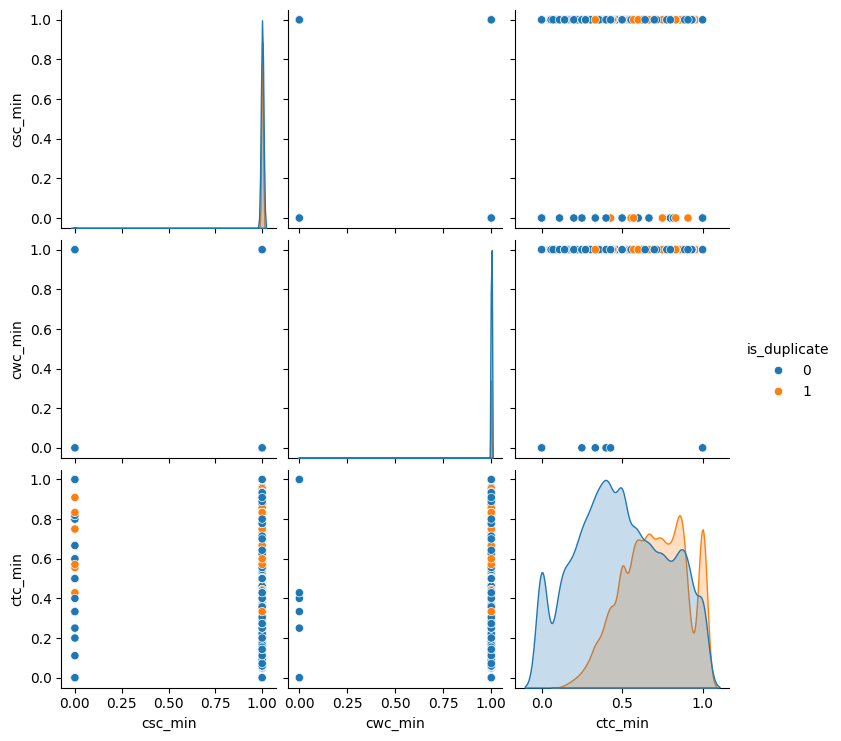

In [ ]:
sns.pairplot(new_df[["csc_min","cwc_min","ctc_min","is_duplicate"]],hue="is_duplicate")

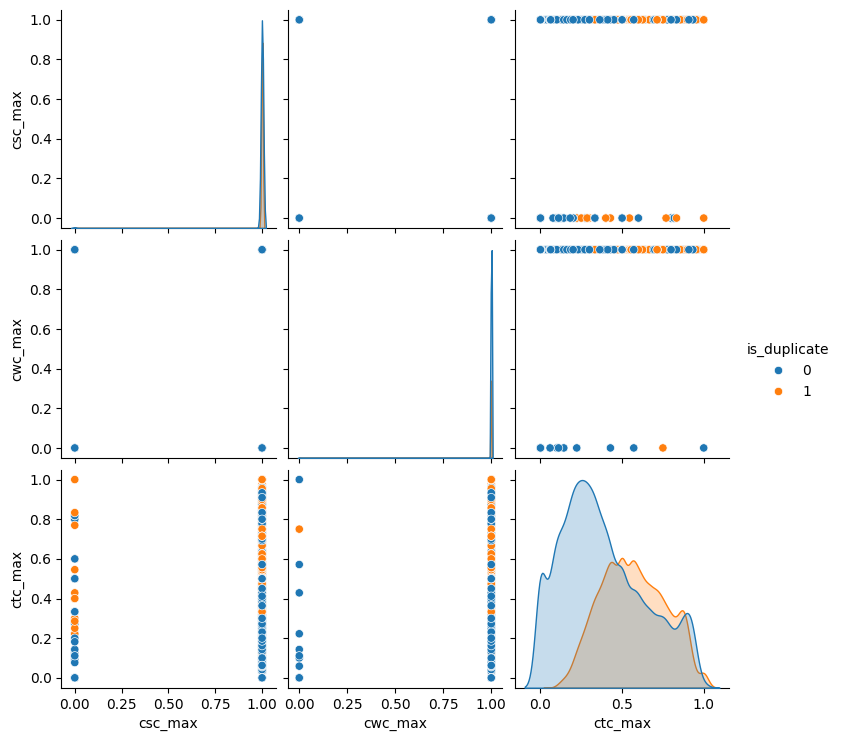

In [ ]:
sns.pairplot(new_df[["csc_max","cwc_max","ctc_max","is_duplicate"]],hue="is_duplicate")

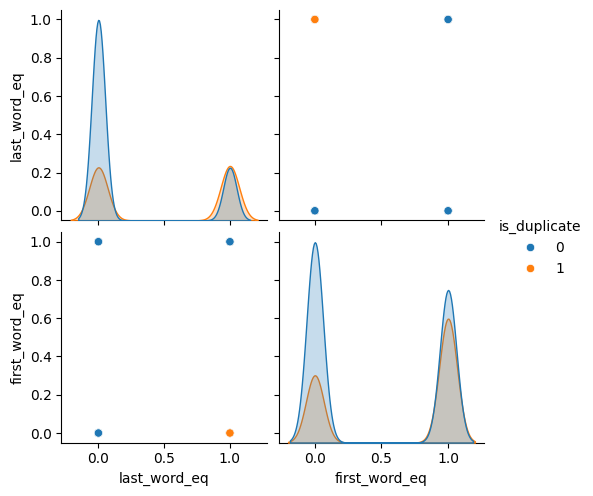

In [ ]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

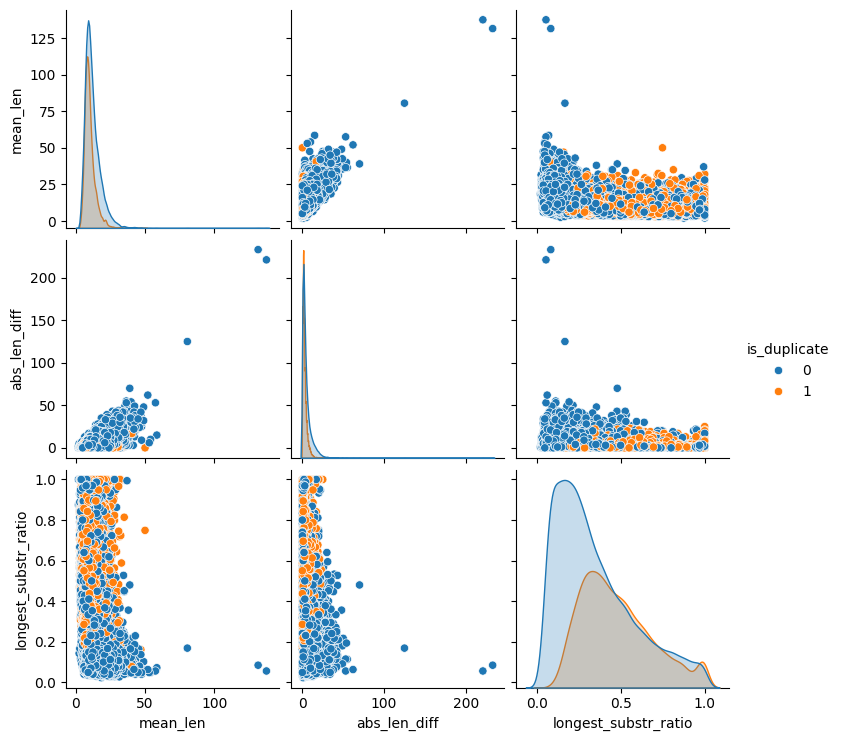

In [ ]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

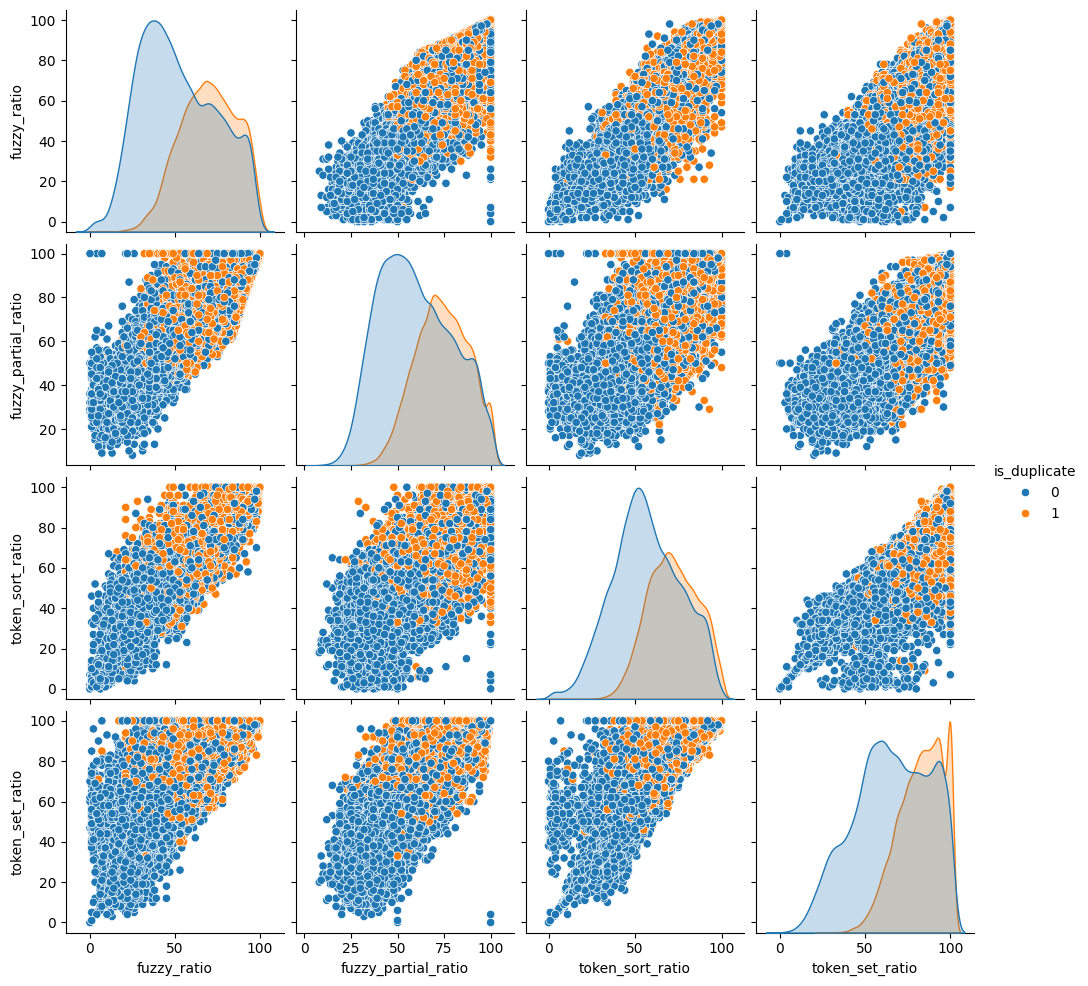

In [ ]:
sns.pairplot(new_df[['fuzzy_ratio', 'fuzzy_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [ ]:
MinMaxScaler=MinMaxScaler()
x=MinMaxScaler.fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'mean_len',
       'abs_len_diff', 'longest_substr_ratio', 'fuzzy_ratio',
       'fuzzy_partial_ratio', 'token_sort_ratio', 'token_set_ratio']])
y=new_df["is_duplicate"].values

In [ ]:
tsne2d=TSNE(n_components=2,n_iter=300,init="random",random_state=42,method="barnes_hut",verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.109s...
[t-SNE] Computed neighbors for 50000 samples in 16.753s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne2d

array([[  2.4521608 ,  -0.22709593],
       [  0.25314385, -12.096864  ],
       [-12.758995  ,   0.39647678],
       ...,
       [  2.9210021 ,   9.251542  ],
       [  8.104088  ,   1.2765477 ],
       [  5.8266582 ,  -2.8613973 ]], dtype=float32)

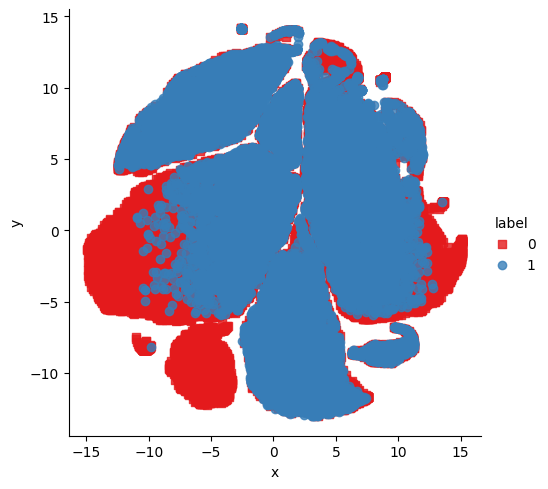

In [ ]:
x_df=pd.DataFrame({"x":tsne2d[:,0],"y":tsne2d[:,1],"label":y})

# draw the plot in appropriate place in the grid

sns.lmplot(data=x_df,x="x",y="y",hue="label",fit_reg=False,palette="Set1",markers=["s","o"])

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.081s...
[t-SNE] Computed neighbors for 30000 samples in 13.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

In [ ]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')


In [ ]:
new_df.head(3)

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086  i am poor but i want to invest  what should i do    
327711  i am from india and live abroad  i met a guy f...   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
398782      76      77            13            13  ...  0.923070   
115086      49      57            12            15  ...  0.583328   
327711     105     120            26            20  ...  0.149999   

        last_word_eq  first_word_eq  mean_len  abs_len_diff  \
398782           1.0            1.0      13.0             0   
115086           1.0            1.0      13.5             3   
327711           0.0            0.0      23.0             6   

        longest_substr_ratio  fuzzy_ratio  fuzzy_partial_ratio  \
398782              0.855263           99                   99   
115086              0.224490           69                   67   
327711              0.047619           26                   27   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                65               74  
327711                34               43  

[3 rows x 28 columns]

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold,StratifiedKFold

In [55]:
final_df=new_df.drop(columns=["id","qid1",	"qid2",	"question1","question2"	,"is_duplicate"])
final_df.head(2)

q1_len  q2_len  q1_num_words  q2_num_words  num_common_word  \
331535      26      44             5             8                2   
45407       34      44             5             7                4   

        total_word  word_share   cwc_min   cwc_max   csc_min  ...   ctc_max  \
331535          13        0.15  0.999950  0.999950  0.999967  ...  0.249997   
45407           12        0.33  0.999967  0.999967  0.999950  ...  0.571420   

        last_word_eq  first_word_eq  mean_len  abs_len_diff  \
331535           1.0            0.0       6.5             3   
45407            1.0            0.0       6.0             2   

        longest_substr_ratio  fuzzy_ratio  fuzzy_partial_ratio  \
331535              0.653846           59                   69   
45407               0.529412           71                   82   

        token_sort_ratio  token_set_ratio  
331535                50               75  
45407                 63               84  

[2 rows x 22 columns]

In [ ]:
corpus=list(new_df["question1"])+list(new_df["question2"])

In [ ]:
cv=CountVectorizer(max_features=5000)

In [ ]:
bow=cv.fit_transform(corpus)

In [ ]:
cv.vocabulary_

{'what': np.int64(2924),
 'is': np.int64(1429),
 'the': np.int64(2679),
 'best': np.int64(333),
 'marketing': np.int64(1644),
 'automation': np.int64(267),
 'tool': np.int64(2721),
 'for': np.int64(1080),
 'small': np.int64(2457),
 'and': np.int64(174),
 'mid': np.int64(1706),
 'size': np.int64(2448),
 'companies': np.int64(582),
 'am': np.int64(159),
 'poor': np.int64(2030),
 'but': np.int64(410),
 'want': np.int64(2882),
 'to': np.int64(2715),
 'invest': np.int64(1413),
 'should': np.int64(2418),
 'do': np.int64(798),
 'from': np.int64(1112),
 'india': np.int64(1363),
 'live': np.int64(1574),
 'abroad': np.int64(67),
 'met': np.int64(1698),
 'guy': np.int64(1218),
 'france': np.int64(1097),
 'in': np.int64(1354),
 'party': np.int64(1926),
 'date': np.int64(705),
 'him': np.int64(1280),
 'how': np.int64(1308),
 'that': np.int64(2678),
 'why': np.int64(2937),
 'so': np.int64(2467),
 'many': np.int64(1638),
 'people': np.int64(1947),
 'hate': np.int64(1249),
 'states': np.int64(2540),
 

In [ ]:
q1_ar,q2_ar=np.vsplit(bow.toarray(),2)

In [ ]:
q1_df=pd.DataFrame(q1_ar,columns=[f"col_{i}" for i in range(5000)])
q2_df=pd.DataFrame(q2_ar,columns=[f"col_{i}" for i in range(5000,10000)])

In [ ]:
final_df.reset_index(drop=True,inplace=True)

In [ ]:
x=pd.concat([final_df,q1_df,q2_df],axis=1)
x.head(2)

q1_len  q2_len  q1_num_words  q2_num_words  num_common_word  total_word  \
0      76      77            13            13               12          26   
1      49      57            12            15                7          22   

   word_share   cwc_min   cwc_max   csc_min  ...  col_9990  col_9991  \
0        0.46  0.999988  0.999988  0.999980  ...         0         0   
1        0.32  0.999967  0.999967  0.999986  ...         0         0   

   col_9992  col_9993  col_9994  col_9995  col_9996  col_9997  col_9998  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   

   col_9999  
0         0  
1         0  

[2 rows x 10022 columns]

In [ ]:
y=new_df.loc[:,"is_duplicate"]


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(24000, 6022)
(6000, 6022)
(24000,)
(6000,)


In [ ]:
param_grid={"n_estimators":[100,150,200],"criterion":["gini","entropy"],"max_depth":[3,5,8],"min_impurity_decrease":[0.1,0.2],"min_samples_split":[2,5,10]}

In [ ]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=43)

In [ ]:
rm=RandomForestClassifier()

In [ ]:
model=GridSearchCV(estimator=rm,param_grid=param_grid,cv=cv,n_jobs=3)

In [ ]:

model.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=3,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8],
                         'min_impurity_decrease': [0.1, 0.2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]})

In [ ]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_impurity_decrease': 0.1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
rm=RandomForestClassifier()

In [ ]:
rm.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
rm.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred=rm.predict(x_test)

In [ ]:
print("accuracy score for rm :-",accuracy_score(y_test,y_pred))

accuracy score for rm :- 0.7909


In [ ]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6324
           1       0.75      0.65      0.70      3676

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
confusion_matrix(y_test,y_pred)

array([[5512,  812],
       [1279, 2397]])

In [ ]:
fpr,tpr,thre=roc_curve(y_test,rm.predict_proba(x_test)[:,1])

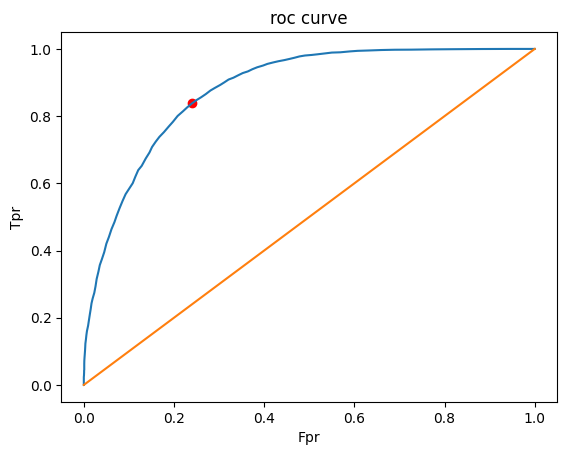

In [ ]:
plt.plot(fpr,tpr)
plt.scatter(fpr[np.argmax(tpr-fpr)],tpr[np.argmax(tpr-fpr)],color="red")
plt.plot([0,1],[0,1])
plt.xlabel("Fpr")
plt.ylabel("Tpr")
plt.title("roc curve")
plt.show()

In [ ]:
roc_auc_score(y_test,y_pred)

np.float64(0.7618338588199505)

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [ ]:
import xgboost



In [ ]:
xgb=xgboost.XGBClassifier()

In [ ]:
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred=xgb.predict(x_test)

In [ ]:
print("accuracy score for rm :-",accuracy_score(y_test,y_pred))

accuracy score for rm :- 0.7919


In [ ]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6324
           1       0.73      0.70      0.71      3676

    accuracy                           0.79     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
confusion_matrix(y_test,y_pred)

array([[5356,  968],
       [1113, 2563]])

In [ ]:
# Now we can represent word in word2vec method

In [56]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [57]:
import gensim

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [59]:
train_word2vec=df.sample(100000,random_state=42)

In [60]:
l1=[]

for sent in train_word2vec["question1"]:

  s=sent_tokenize(sent)
  for i in s:
    l1.append(simple_preprocess(i))



In [61]:
l2=[]

for sent in train_word2vec["question2"]:

  s=sent_tokenize(sent)
  for i in s:
    l2.append(simple_preprocess(i))


In [62]:
corpus=l1+l2

In [63]:
len(corpus)

223701

In [64]:
word_vec=Word2Vec(window=5,min_count=1,workers=4,vector_size=200)

word_vec.build_vocab(corpus)

In [65]:
word_vec.corpus_count

223701

In [66]:
word_vec.train(corpus,total_examples=word_vec.corpus_count,epochs=10)

(15108590, 20834330)

In [67]:
word_vec.wv.index_to_key

['the',
 'what',
 'is',
 'how',
 'to',
 'in',
 'do',
 'of',
 'are',
 'and',
 'can',
 'for',
 'you',
 'why',
 'my',
 'best',
 'it',
 'on',
 'does',
 'or',
 'if',
 'which',
 'be',
 'some',
 'have',
 'that',
 'with',
 'get',
 'should',
 'an',
 'from',
 'your',
 'india',
 'will',
 'when',
 'people',
 'who',
 'at',
 'like',
 'good',
 'there',
 'would',
 'as',
 'about',
 'not',
 'between',
 'one',
 'most',
 'we',
 'way',
 'make',
 'did',
 'quora',
 'by',
 'where',
 'me',
 'any',
 'was',
 'life',
 'so',
 'they',
 'after',
 'this',
 'time',
 'money',
 'know',
 'am',
 'difference',
 'has',
 'learn',
 'someone',
 'new',
 'use',
 'much',
 'think',
 'their',
 'many',
 'all',
 'work',
 'indian',
 'than',
 'ever',
 'trump',
 'find',
 'world',
 'but',
 'more',
 'without',
 'other',
 'out',
 'become',
 'online',
 'better',
 'start',
 'first',
 'year',
 'want',
 'mean',
 'job',
 'english',
 'us',
 'don',
 'he',
 'love',
 'could',
 'into',
 'up',
 'take',
 'feel',
 'day',
 'possible',
 'things',
 'go',


In [68]:
word_vec.wv["india"].shape

(200,)

In [77]:
def word_vector(doc):

  doc=[word_vec.wv[word] if word in word_vec.wv.index_to_key else np.zeros(word_vec.vector_size) for word in doc.split()]
  if len(doc)==0:
    return np.zeros(word_vec.vector_size)
  else:
    return np.mean(doc,axis=0)

In [78]:
import tqdm
l1=[]
for i in tqdm.tqdm(new_df["question1"]):
  l1.append(word_vector(i))


100%|██████████| 50000/50000 [01:05<00:00, 765.85it/s]


In [71]:
def word_vector(doc):
  doc=[word_vec.wv[word] if word in word_vec.wv.index_to_key else np.zeros(word_vec.vector_size,dtype=np.float32) for word in doc.split()]

  if len(doc)==0:
    return np.zeros(word_vec.vector_size,dtype=np.float32)
  else:
    return np.mean(doc,axis=0)

In [72]:
import tqdm
l2=[]
for i in tqdm.tqdm(new_df["question2"]):
  l2.append(list(word_vector(i)))

100%|██████████| 50000/50000 [01:08<00:00, 728.60it/s]


In [79]:
type(l2)

list

In [80]:
q1_df=pd.DataFrame(l1,columns=[f"col_{i}" for i in range(200)])
q2_df=pd.DataFrame(l2,columns=[f"col_{i}" for i in range(200,400)])


In [81]:
final_df.reset_index(drop=True,inplace=True)

In [82]:
x1=pd.concat([final_df,q1_df,q2_df],axis=1)

In [83]:
x1.head(2)

q1_len  q2_len  q1_num_words  q2_num_words  num_common_word  total_word  \
0      26      44             5             8                2          13   
1      34      44             5             7                4          12   

   word_share   cwc_min   cwc_max   csc_min  ...   col_390   col_391  \
0        0.15  0.999950  0.999950  0.999967  ... -0.082182  0.670542   
1        0.33  0.999967  0.999967  0.999950  ... -0.749082  0.136376   

    col_392   col_393   col_394   col_395   col_396   col_397   col_398  \
0  0.719129  0.232188  0.394734  0.270079  0.121516 -0.158003 -0.496467   
1  0.098312  0.401171 -0.013505  0.471529 -0.254882  0.494744  0.221467   

    col_399  
0  0.506810  
1 -0.065605  

[2 rows x 422 columns]

In [84]:
y=new_df.loc[:,"is_duplicate"]

In [85]:
x_train,x_test,y_train,y_test=train_test_split(x1,y,test_size=0.2,random_state=42)

In [ ]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=43)

In [ ]:
param_grid={"n_estimators":[100,150,200],"criterion":["gini","entropy"],"max_depth":[3,5,8],"min_impurity_decrease":[0.1,0.09,0.2],"min_samples_split":[2,5,10]}

In [ ]:
rm=RandomForestClassifier()

In [ ]:
model=GridSearchCV(estimator=rm,param_grid=param_grid,cv=cv,n_jobs=3)

In [ ]:
model.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=3,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8],
                         'min_impurity_decrease': [0.1, 0.09, 0.2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]})

In [86]:
rm=RandomForestClassifier()


In [87]:
rm.fit(x_train,y_train)

RandomForestClassifier()

In [88]:
y_pred=rm.predict(x_test)

In [89]:
accuracy_score(y_test,y_pred)

0.7868

In [90]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      6328
           1       0.72      0.70      0.71      3672

    accuracy                           0.79     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.79      0.79      0.79     10000



In [91]:
confusion_matrix(y_test,y_pred)

array([[5309, 1019],
       [1113, 2559]])

In [ ]:
import xgboost

from xgboost import XGBClassifier

xgb=XGBClassifier()

xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred=xgb.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.7733333333333333

In [ ]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3799
           1       0.70      0.68      0.69      2201

    accuracy                           0.77      6000
   macro avg       0.76      0.75      0.75      6000
weighted avg       0.77      0.77      0.77      6000



#### Lets build testing pipeline

In [ ]:
import re

In [92]:

def Preprocess(q):

  q=str(q).lower().strip()

  # replace certain special Charcters with their string equivalents

  q=q.replace("%"," percent ")
  q=q.replace("₹"," rupee ")
  q=q.replace("$"," dollar ")
  q=q.replace("€"," euro ")
  q=q.replace("@"," at ")

  # The pattern '[math]' appears around 900 time in the whole dataset

  q=q.replace("[math]","")

  # replace some number with string equivalents

  q=q.replace(",000,000,000 ","b")
  q=q.replace(",000,000 ","m")
  q=q.replace(",000 ","k")

  q=re.sub(r"([0-9]+)000000000",r"\1b",q)
  q=re.sub(r"([0-9]+)000000",r"\1m",q)
  q=re.sub(r"([0-9]+)000",r"\1k",q)

  # Deconstructing words
  # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  # https://stackoverflow.com/a/19794953

  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

  q=" ".join([contractions[word] if word in contractions else word for word in q.split()])

  q=q.replace("'ve"," have ")
  q=q.replace("n't"," not ")
  q=q.replace("'re"," are ")
  q=q.replace("'ll"," will ")

  # removing html tag

  q=BeautifulSoup(q,"html.parser")
  q=q.get_text()

  # remove punctuation

  pattern=re.compile("\W")
  q=re.sub(pattern," ",q)

  return q



In [93]:
Preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done '

In [94]:
def test_fetech_token_features(q1,q2):

  SAFE_DIV=0.0001
  token_features=[0.0]*8
  stopword=stopwords.words("english")

  # converting the sentence into token

  # conversting the sentence into token
  q1_tokens=q1.split()
  q2_tokens=q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  # Get the common word count

  q1_words=[word for word in q1_tokens if word not in stopword]
  q2_words=[word for word in q2_tokens if word not in stopword]

  q1_words=set(map(lambda word:word.lower().strip(),q1_words))
  q2_words=set(map(lambda word:word.lower().strip(),q2_words))

  common_word_count=len(q1_words.intersection(q2_words))

  token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
  token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)

  # get the common stopword

  q1_stopwords=[word for word in q1_tokens if word in stopword]
  q2_stopwords=[word for word in q2_tokens if word in stopword]

  q1_stopwords=set(map(lambda word:word.lower().strip(),q1_stopwords))
  q2_stopwords=set(map(lambda word:word.lower().strip(),q2_stopwords))

  common_stop_word_count=len(q1_stopwords.intersection(q2_stopwords))
  token_features[2]=common_stop_word_count/(min(len(q1_stopwords),len(q2_stopwords))+SAFE_DIV)
  token_features[3]=common_stop_word_count/(max(len(q1_stopwords),len(q2_stopwords))+SAFE_DIV)

  # common token count

  q1_token=set(q1)
  q2_token=set(q2)

  common_token_count=len(q1_token.intersection(q2_token))
  token_features[4]=common_token_count/(min(len(q1_token),len(q2_token))+SAFE_DIV)
  token_features[5]=common_token_count/(max(len(q1_token),len(q2_token))+SAFE_DIV)

  # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

  # first word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])

  return token_features


In [95]:
test_fetech_token_features("how are you","how are you")

[0.0,
 0.0,
 0.9999666677777407,
 0.9999666677777407,
 0.9999888890123443,
 0.9999888890123443,
 1,
 1]

In [96]:
def test_fetech_length_features(q1,q2):

  length_features=[0.0]*3



  len_q1=len(q1.split())
  len_q2=len(q2.split())

  if q1==0 or q2==0:
    return length_features

  # mean length
  length_features[0]=(len_q1+len_q2)/2

  # absolute diffrence

  length_features[1]=abs(len_q1-len_q2)


  # longest subtring ratio

  strg=list(distance.lcsubstrings(q1,q2))

  length_features[2]=len(strg[0])/(min(len(q1),len(q2)+1))

  return length_features

In [97]:
test_fetech_length_features("how are you","how are you")

[3.0, 0, 1.0]

In [98]:
def test_fetch_fuzzy_features(q1,q2):

  fuzzy_features=[0.0]*4

  fuzzy_features[0]=fuzz.QRatio(q1,q2)
  fuzzy_features[1]=fuzz.partial_ratio(q1,q2)
  fuzzy_features[2]=fuzz.token_sort_ratio(q1,q2)
  fuzzy_features[3]=fuzz.token_set_ratio(q1,q2)

  return fuzzy_features

In [99]:
test_fetch_fuzzy_features("how are you","how are you")

[100, 100, 100, 100]

In [100]:
def test_common_words(q1,q2):

  q1=q1.split()
  q2=q2.split()

  return len(set(q1).intersection(set(q2)))



In [101]:
def test_total_words(q1,q2):

  return len(q1.split())+len(q2.split())

In [102]:
def query_point_creator(q1,q2):

  input_query=[]

  q1=Preprocess(q1)
  q2=Preprocess(q2)

  # fetch basic features

  # len of question
  input_query.append(len(q1))
  input_query.append(len(q2))

  # number of word
  input_query.append(len(q1.split(" ")))
  input_query.append(len(q2.split(" ")))

  # common word count
  input_query.append(test_common_words(q1,q2))

  # total_words
  input_query.append(test_total_words(q1,q2))

  # word share
  input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))


  # fetch token features

  token_features=test_fetech_token_features(q1,q2)

  input_query.extend(token_features)

  # fetch length features

  length_features=test_fetech_length_features(q1,q2)
  input_query.extend(length_features)

  # fetch fuzzy features

  fuzzy_features=test_fetch_fuzzy_features(q1,q2)
  input_query.extend(fuzzy_features)

  # applying word2vec model

  q1_split=q1.split()
  q2_split=q2.split()

  doc=[word_vec.wv[word] if word in word_vec.wv.index_to_key else np.zeros(word_vec.vector_size) for word in q1_split ]
  if len(doc)==0:
    q1_vec=np.zeros(word_vec.vector_size)
  else:
    q1_vec=np.mean(doc,axis=0)

  doc=[word_vec.wv[word] if word in word_vec.wv.index_to_key else np.zeros(word_vec.vector_size) for word in q2_split ]
  if len(doc)==0:
    q2_vec=np.zeros(word_vec.vector_size)
  else:
    q2_vec=np.mean(doc,axis=0)

  return np.hstack((np.array(input_query),q1_vec,q2_vec))






In [103]:
q1=query_point_creator("how are you","how are you")

In [104]:
q1.shape

(422,)

In [105]:
rm.predict([query_point_creator("how are you","how are you")])

array([0])

In [106]:
q1="i am quite poor and i want to be very rich  what do i do"
q2="i am poor but i want to invest  what should i do"

In [107]:
rm.predict([query_point_creator(q1,q2)])

array([1])

In [108]:
import pickle

In [109]:
pickle.dump(rm,open("model.pkl","wb"))
pickle.dump(word_vec,open("word_vec.pkl","wb"))

In [ ]:
# how import both model

m1=pickle.load(open("model.pkl","rb"))
w1=pickle.load(open("word_vec.pkl","rb"))

In [ ]:
m1.predict([query_point_creator(q1,q2)])

array([0])

In [ ]:
m1.predict([q1])

array([1])